# Homework 3

In [1]:
import folium
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

# 1. Eurostat dataset 

The dataset we found presents unemployment rates for different age groups. According to the website, the unemployment rate represents the percentage of unemployed persons in the labour force. The labour force is the sum of employed and unemployed people. The indicator is based on the EU Labour Force Survey. Moreover the last update of this dataset was made the 27th of october 2017 and these are the 2016's rates in order to have a complete year.

We decided to use this dataset since it includes the european unemployment rates at a rather recent date. Moreover, it has data for most of the EU member countries, and also a few countries that are on the european area but not EU members. That was necessary as we want to the compare those rates with the Switzerland one. Finally, the dataset includes different ranges of age that could be interesting to analyse.

In [2]:
# Thus, we get the dataset we chose from eurostat
eurostat_df = pd.read_excel('data/eurostat_table.xls', na_values=':')
eurostat_df.head()

,geo,From 15 to 24 years,From 15 to 74 years,From 20 to 64 years,From 25 to 29 years,From 25 to 54 years,From 55 to 64 years
0,EU (28 countries),18.7,8.6,8.4,11.2,7.9,6.5
1,EU (27 countries),18.6,8.5,8.3,11.2,7.9,6.5
2,Euro area (19 countries),20.9,10.0,9.9,13.6,9.5,7.6
3,Euro area (18 countries),21.0,10.1,9.9,13.7,9.5,7.6
4,Belgium,20.1,7.8,7.7,10.8,7.1,5.7


We have to link every country of our dataset to the id of the topology json we were given, in order to match each rate to its corresponding country. 

In [3]:
# We load the topology json
topo_eurostat_path = r'topojson/europe.topojson.json'
topo_eurostat_json = json.load(open(topo_eurostat_path))

# A dict that link every country to its id that are used in the json file 
# you gave us that shows the borders of the european countries.
country_to_id = {"Azerbaijan":"AZ","Albania":"AL","Armenia":"AM","Bosnia and Herzegovina":"BA",
                "Bulgaria":"BG","Cyprus":"CY","Denmark":"DK","Ireland":"IE",
                "Estonia":"EE","Austria":"AT","Czech Republic":"CZ",
                "Finland":"FI","France":"FR","Georgia":"GE","Germany":"DE",
                "Greece":"GR","Croatia":"HR","Hungary":"HU","Iceland":"IS",
                "Israel":"IL","Italy":"IT","Latvia":"LV","Belarus":"BY",
                "Lithuania":"LT","Slovakia":"SK","Liechtenstein":"LI",
                "Former Yugoslav Republic of Macedonia, the":"MK","Malta":"MT",
                "Belgium":"BE","Faroe Islands":"FO","Andorra":"AD","Luxembourg":"LU",
                "Monaco":"MC","Montenegro":"ME","Netherlands":"NL","Norway":"NO",
                "Poland":"PL","Portugal":"PT","Romania":"RO","Republic of Moldova":"MD",
                "Slovenia":"SI","Spain":"ES","Sweden":"SE","Switzerland":"CH","Turkey":"TR",
                "United Kingdom":"GB","Ukraine":"UA","San Marino":"SM","Serbia":"RS",
                "Holy See (Vatican City)":"VA","Russia":"RU"}

# We create a column with the id of each country
eurostat_df['id'] = eurostat_df.geo.map(country_to_id).drop(eurostat_df.index[[0,1,2,3]])
eurostat_df.dropna(inplace=True)

# Removing countries that are not in the DataFrame
new_country = []
for country in topo_eurostat_json['objects']['europe']['geometries']:
    if country['id'] in list(eurostat_df['id']):
        new_country.append(country)
        
topo_eurostat_json['objects']['europe']['geometries'] = new_country

In order to make the visualization more intuitive and expressive, we decided to add markers on our choropleth map in order to show the name and the specific unemployment rate of each country.
<br>
Thus, we use a dataset that links every country to its location using coordinates.

In [4]:
coord_countries = pd.read_csv('data/coord_countries.csv', delimiter=',').drop('country', 1)
coord_countries = coord_countries[coord_countries['id'].isin(list(eurostat_df['id']))]
eurostat_df = pd.merge(eurostat_df, coord_countries, on='id')
eurostat_df.head()

,geo,From 15 to 24 years,From 15 to 74 years,From 20 to 64 years,From 25 to 29 years,From 25 to 54 years,From 55 to 64 years,id,latitude,longitude
0,Belgium,20.1,7.8,7.7,10.8,7.1,5.7,BE,50.503887,4.469936
1,Bulgaria,17.2,7.6,7.6,9.9,7.1,7.3,BG,42.733883,25.485830
2,Czech Republic,10.5,4.0,3.9,5.5,3.5,3.8,CZ,49.817492,15.472962
3,Denmark,12.0,6.2,5.7,9.4,5.5,4.0,DK,56.263920,9.501785
4,Germany,7.1,4.1,4.1,5.3,3.9,3.9,DE,51.165691,10.451526


In [5]:
def addpopup(current_map, dataframe, location_column, data_column):
    ''' 
    Function that creates popups on a choropleth map to display the name and 
    the unemployement rate of every country
    '''
    for index, row in dataframe.iterrows():
        loc = [row['latitude'], row['longitude']]
        pop = row[location_column] + '<br> Unemployement Rate: ' + str(row[data_column])
        folium.RegularPolygonMarker(loc, radius=6, popup=pop, fill_color='grey', number_of_sides=10,).add_to(current_map)

First of all, we decide to create the choropleth map of the unemployement rates from 15 to 74 years old because it was the largest interval we had. Thus it represents everybody that can search for work, with no age distinction, hence the most general setting.

For the color chosen from the map, we chose the YlGnBu colormap, since it is colorblind-proof, and also, not aggressive at all. Hence we will use it for all of our maps.

In terms of scale, we tried out a few techniques possible such as the standard deviation one, a linear space based on minimum and max value, or even Jenks or quantiles, but decided that the default one was always the one split the data better each and everytime. Hence we stuck with the default scale throughout the analysis.

In [6]:
# We choose the location and the started zoom of our map
eu_map = folium.Map(location=[53.644638,18.193359], tiles='cartodbpositron', zoom_start=4)

# We build our choropleth map of the unemployment rate in Europe
eu_map.choropleth(geo_data=topo_eurostat_json, data=eurostat_df, topojson='objects.europe',
             columns=['id', 'From 15 to 74 years'],
             key_on='feature.id', 
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment by country in Europe (15 to 74 years)')

addpopup(eu_map, eurostat_df, 'geo', 'From 15 to 74 years')
    
eu_map

**The grey points are clickable markers that allow to see the name of the country and its unemployement rate.**

As we can see on this map, the Switzerland unemployment rate is rather low compared to the rest of Europe. In fact, it's one of the lowest of Europe !

Then, we decided to map other age intervals in order to see that it has changed something for Switzerland. Thus, we try for people from 20 to 64 years old. We do this because 64 years old is closer than 74 to the average retirement age in Europe and furthermore, we stop considering underaged workers.

In [7]:
# We choose the location and the started zoom of our map
eu_map = folium.Map(location=[53.644638,18.193359], tiles='cartodbpositron', zoom_start=4)

# We build our choropleth map of the unemployment rate in Europe
eu_map.choropleth(geo_data=topo_eurostat_json, data=eurostat_df, topojson='objects.europe',
             columns=['id', 'From 20 to 64 years'],
             key_on='feature.id', 
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment y country in Europe (20 to 64 years)')

addpopup(eu_map, eurostat_df, 'geo', 'From 20 to 64 years')

eu_map

As we can see, it does not affect the comparison of the unemployement rate between Switzerland and the rest of Europe. In fact, it only affects a few countries such as Latvia.

However, it would be interesting to analyze smaller age intervals and compare yonug to older people. Thus, we start by the young namely, from 15 to 24 years old.

In [8]:
# We choose the location and the started zoom of our map
eu_map = folium.Map(location=[53.644638,18.193359], tiles='cartodbpositron', zoom_start=4)

# We build our choropleth map of the unemployment rate in Europe
eu_map.choropleth(geo_data=topo_eurostat_json, data=eurostat_df, topojson='objects.europe',
             columns=['id', 'From 15 to 24 years'],
             key_on='feature.id', 
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment in Europe for each country (15 to 24 years)')

addpopup(eu_map, eurostat_df, 'geo', 'From 15 to 24 years')

eu_map

Event if most countries were categorized in the same bin, the scale has greatly changed. In fact, it seems that the unemployement rate is bigger for every country which seems logic for this age interval: young people are more likely to be unemployed. However, the rise is not proportional, thus, Switzerland's unemployement rate remains extremely low compared to the rest of the Europe. 

Let's take a look at the rate of unemployment of people from 25 to 54 years old:

In [9]:
# We choose the location and the started zoom of our map
eu_map = folium.Map(location=[53.644638,18.193359], tiles='cartodbpositron', zoom_start=4)

# We build our choropleth map of the unemployment rate in Europe
eu_map.choropleth(geo_data=topo_eurostat_json, data=eurostat_df, topojson='objects.europe',
             columns=['id', 'From 25 to 54 years'],
             key_on='feature.id', 
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment in Europe for each country (25 to 54 years)')

addpopup(eu_map, eurostat_df, 'geo', 'From 25 to 54 years')

eu_map

This interval is rather large and very typical of the working population, that is why this map seems almost identical to the ones for 15-74 and 20-64 years old.

Finally, the rate for the 55 to 64 years old interval:

In [10]:
# We choose the location and the started zoom of our map
eu_map = folium.Map(location=[53.644638,18.193359], tiles='cartodbpositron', zoom_start=4)

# We build our choropleth map of the unemployment rate in Europe
eu_map.choropleth(geo_data=topo_eurostat_json, data=eurostat_df, topojson='objects.europe',
             columns=['id', 'From 55 to 64 years'],
             key_on='feature.id', 
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment in Europe for each country (55 to 64 years)')

addpopup(eu_map, eurostat_df, 'geo', 'From 55 to 64 years')

eu_map

We can see that quite a few countries have higher unemployment rates for older people, but not Switzerland or Sweden for example. Thus, it seems that it is easier in these countries to find or to keep a job when you are older than in the rest of Europe.

# 2. Amstat
As far as choosing the right dataset, we decided to go with the full 2016 year. This is partly due to the fact that there was means for us to pickup the active population data from an official swiss website. Mostly though, the choice was made since the employment rate is seasonal, it fluctuates usually quite the same way.

In [11]:
# The data gets really messy, so let's clean it up
chomage_df = pd.read_csv('data/unemployment_rate_ages_2016.csv', delimiter=',', encoding='utf-16')
chomage_df = chomage_df.drop(axis=1, labels=['Total.1', 'Total', 'Total.2', 'Total.3']).T.reset_index().T
chomage_df.drop(axis=0, labels="index", inplace=True)

# We select only the important columns
rate_index = np.arange(3, 51, 4)
unemployment_index = np.arange(4, 52, 4)
job_seekers_index = np.arange(5, 53, 4)
job_seek_employ_index = np.arange(6, 54, 4)

chomage_df.drop(axis=0 ,labels=0, inplace=True)
chomage_df.drop(axis=1, labels=2, inplace=True)

# Clean up the data
def clean_up(series):
    return series.replace(regex=True,to_replace=r'\D',value=r'').astype(int)

chomage_df[rate_index] = chomage_df[rate_index].replace('...', np.nan).astype(float)
chomage_df[unemployment_index] = clean_up(chomage_df[unemployment_index])
chomage_df[job_seekers_index] = clean_up(chomage_df[job_seekers_index])
chomage_df[job_seek_employ_index] = clean_up(chomage_df[job_seek_employ_index])

In order to mean together the rates we need to compute an harmonic mean. We use two definitions of the harmonic mean, one usefull for dataframes and the other one usefull for normal harmonic means. 

In [12]:
def harmonic_mean(data=[], df= None, columns=None):
    mean_rate = 0
    if len(data) == 0:
        for i in columns:
            mean_rate += 1 / df[i]
        data = columns
    else:
        for i in data:
            mean_rate += 1 / i
    return len(data) / mean_rate

# Ok, let's now focus on computing the yearly mean for each column
mean_rate = harmonic_mean(df=chomage_df, columns=rate_index)

# Setting the mean to each column and removing the unused ones
chomage_df['Moyenne_taux'] = mean_rate
chomage_df.drop(rate_index, axis=1, inplace=True)

chomage_df['Moyenne Chomeurs Inscrits'] = chomage_df[unemployment_index].mean(1)
chomage_df.drop(unemployment_index, axis=1, inplace=True)

chomage_df['Moyenne Demandeurs d emploi'] = chomage_df[job_seekers_index].mean(1)
chomage_df.drop(job_seekers_index, axis=1, inplace=True)

chomage_df['Moyenne Demandeurs d emploi avec job'] = chomage_df[job_seek_employ_index].mean(1)
chomage_df.drop(job_seek_employ_index, axis=1, inplace=True)

# Rename a few columns
chomage_df.rename(columns={0:"Canton", 1:"Classes d'âge par étapes de 5 ans"}, inplace=True)


chomage_df.head()

,Canton,Classes d'âge par étapes de 5 ans,Moyenne_taux,Moyenne Chomeurs Inscrits,Moyenne Demandeurs d emploi,Moyenne Demandeurs d emploi avec job
1,Zurich,15-19 ans,3.555219,1145.250000,1342.833333,197.583333
2,Zurich,20-24 ans,4.250928,2566.166667,2902.833333,336.666667
3,Zurich,25-29 ans,4.212769,3761.000000,4456.416667,695.416667
4,Zurich,30-34 ans,4.172612,4436.000000,5329.583333,893.583333
5,Zurich,35-39 ans,4.085799,4084.583333,4962.750000,878.166667


We took a look at how the website itself defines ["Taux de chômage"](https://www.amstat.ch/v2/definition.jsp?lang=fr) and turns out it is the "Nombre de chômeurs inscrits au jour de référence (dernier jour du mois) divisé par le nombre de personnes actives, multiplié par 100" which translates to the "Chômeurs inscrits" column divided by the "active population".

Now the confédération defines these rates as being the number of people looking for a job divided by the size of the active population (scaled by 100). If we want to take a look at that, we are going to need to add in a column which adds to the "Taux de chômage" the number of "Demandeurs d'emploi non chômeurs" which are people looking for a job while already having one.

We will then later take a look at the current column that we have, namely the unemployment rate **whithout** these active people.

In [13]:
# We load the topology json
topo_path = r'topojson/ch-cantons.topojson.json'
topo_json = json.load(open(topo_path))

# Let's link each canton column to its Swiss ID
canton_to_acronym = {'Berne':'BE', 'Soleure': 'SO', 'Bâle-Ville':'BS', 'Bâle-Campagne':'BL',
'Argovie':'AG', 'Zurich':'ZH', 'Glaris':'GL', 'Schaffhouse':'SH', 'Appenzell Rhodes-Extérieures':'AR',
'Appenzell Rhodes-Intérieures':'AI', 'St-Gall':'SG', 'Grisons':'GR', 'Thurgovie':'TG', 'Lucerne':'LU',
'Uri':'UR', 'Schwyz':'SZ', 'Obwald':'OW', 'Nidwald':'NW', 'Zoug':'ZG', 'Vaud':'VD', 'Valais':'VS',
'Genève':'GE', 'Fribourg':'FR', 'Neuchâtel':'NE', 'Jura':'JU', 'Tessin':'TI'}

# Picking up the dataframe from above
chomage_age_df = chomage_df.copy()
# Creating a column from which to pick the id from
chomage_age_df['Canton acronym'] = chomage_age_df.Canton.map(canton_to_acronym)


# We add in a column representing the Active population in Switzerland
chomage_age_df['Active population'] = chomage_age_df['Moyenne Chomeurs Inscrits'] / chomage_age_df['Moyenne_taux'] * 100
# And one for the Swiss Confederation definition of unemployment
chomage_age_df['Swiss Confederation unemployment'] =  (chomage_age_df['Moyenne Chomeurs Inscrits'] + chomage_age_df["Moyenne Demandeurs d emploi avec job"]) / chomage_age_df['Active population'] * 100

# The final DataFrame
chomage_age_df.head()

,Canton,Classes d'âge par étapes de 5 ans,Moyenne_taux,Moyenne Chomeurs Inscrits,Moyenne Demandeurs d emploi,Moyenne Demandeurs d emploi avec job,Canton acronym,Active population,Swiss Confederation unemployment
1,Zurich,15-19 ans,3.555219,1145.250000,1342.833333,197.583333,ZH,32213.203768,4.168581
2,Zurich,20-24 ans,4.250928,2566.166667,2902.833333,336.666667,ZH,60367.212727,4.808626
3,Zurich,25-29 ans,4.212769,3761.000000,4456.416667,695.416667,ZH,89276.188477,4.991719
4,Zurich,30-34 ans,4.172612,4436.000000,5329.583333,893.583333,ZH,106312.309343,5.013139
5,Zurich,35-39 ans,4.085799,4084.583333,4962.750000,878.166667,ZH,99970.245921,4.964227


We use a dataset that links every canton to its location using coordinates. That will allow us to add markers on our choropleth map in order to show the name and the specific unemployment rate of each canton.

In [14]:
canton_coord = pd.read_csv('data/canton_coord.csv', delimiter=',').drop('canton', 1)
canton_coord = canton_coord[canton_coord['Canton acronym'].isin(list(chomage_age_df['Canton acronym']))]
chomage_age_df = pd.merge(chomage_age_df, canton_coord, on='Canton acronym')

# Applying the harmonic mean by Canton
chomage_general_harmean = pd.DataFrame(chomage_age_df.groupby(
    ["Canton", "Canton acronym", "latitude", "longitude"])
    ['Swiss Confederation unemployment'].apply(harmonic_mean)).reset_index()
chomage_general_harmean.head()

,Canton,Canton acronym,latitude,longitude,Swiss Confederation unemployment
0,Appenzell Rhodes-Extérieures,AR,47.366481,9.300092,2.650054
1,Appenzell Rhodes-Intérieures,AI,47.316192,9.431657,NaN
2,Argovie,AG,47.387666,8.255429,4.115342
3,Berne,BE,46.798862,7.708070,3.358115
4,Bâle-Campagne,BL,47.441812,7.764400,3.386684


Let's take a look at the mapped unemployment rates, taking the same colormap as before and same scale.

In [15]:
# Ok now let's show the unemployment rate on the map
ch_map = folium.Map(location=[46.8345103,8.2388396], tiles='cartodbpositron', zoom_start=7.5)

# We use the "Swiss Confederation unemployment" column for the data as created right before
ch_map.choropleth(geo_data=topo_json, data=chomage_general_harmean, topojson='objects.cantons',
             columns=['Canton acronym', 'Swiss Confederation unemployment'],
             key_on='feature.id', 
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment by Canton in Switzerland (Swiss def., in %)')

addpopup(ch_map, chomage_general_harmean, 'Canton', 'Swiss Confederation unemployment')

# And voilà !
ch_map

As we can see, there are entire regions more prone to unemployment in Switzerland. In the french or italian speaking cantons, the unemployment is clearly higher than in the german-speaking parts of Switzerland. It also seems like most cantons in direct contact with a foreign country have a rise in unemployment rate compared to the others.

But what if we take a look at the unemployment rate without these active members looking for a job ?

In [16]:
chomage_not_swiss_harmean = pd.DataFrame(chomage_age_df.groupby(
    ["Canton", "Canton acronym", "latitude", "longitude"])
    ['Moyenne_taux'].apply(harmonic_mean)).reset_index()

# Ok now let's show the unemployment rate as defined without 
# the active population looking for a job on the map
ch_map = folium.Map(location=[46.8345103,8.2388396], tiles='cartodbpositron', zoom_start=7.5)

# We use the "Taux de chômage" column for the data as discussed before
ch_map.choropleth(geo_data=topo_json, data=chomage_not_swiss_harmean, topojson='objects.cantons',
             columns=['Canton acronym', 'Moyenne_taux'],
             key_on='feature.id',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment by Canton in Switzerland (Our def., in %)')

addpopup(ch_map, chomage_not_swiss_harmean, 'Canton', 'Moyenne_taux')

ch_map

Displaying the map on almost the same threshold scale as right before, we can clearly see a difference in unemployment. In fact under this definition, we go to a maximum of around 4% of unemployment, which is a 33% improvement compared to the Swiss definition. Plotting the data under different scales and with a different definition can completely change the perception of the subject. Now there are only 2 cantons that seem to have a higher unemployment rate, the Jura and Neuchâtel. But compared to the previous unemployment rate it doesn't look so bad, and more "even" around the country.

We will now focus on the last definition we implied, without the active population. 

We want now to compare this map to another with a few fluctuations in ages. Let's take a look at the young population that we will define as 15 to 24 years old compared to the older active populations of 25 to 49 years old and then the elderly (50+).

In [17]:
# The unemployment concerning only young people
young_classes = ["15-19 ans", "20-24 ans"]
chomage_age_young_df = chomage_age_df[chomage_age_df["Classes d'âge par étapes de 5 ans"].isin(young_classes)]

chomage_young_harmean = pd.DataFrame(chomage_age_young_df.groupby(
    ["Canton", "Canton acronym", "latitude", "longitude"])
    ['Moyenne_taux'].apply(harmonic_mean)).reset_index()

ch_map = folium.Map(location=[46.8345103,8.2388396], tiles='cartodbpositron', zoom_start=7.5)

ch_map.choropleth(geo_data=topo_json, data=chomage_young_harmean, topojson='objects.cantons',
             columns=['Canton acronym', 'Moyenne_taux'],
             key_on='feature.id',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployed young people by Canton in Switzerland (in %)')

addpopup(ch_map, chomage_young_harmean, 'Canton', 'Moyenne_taux')

ch_map

Now we can clearly see a schoking difference in unemployment rate compared to the general mean of the country that we saw before. It's simple, most of the country is between 2 and 5% unemployment when taking into account only the young population. For the whole population, we were looking at rates between 1 and 3%. 

What about the older population ?

In [18]:
# The unemployment concerning older people, from 30 to 49 years old
older_classes = ["25-29 ans", "30-34 ans", "35-39 ans", "40-44 ans", "45-49 ans"]
chomage_age_older_df = chomage_age_df[chomage_age_df["Classes d'âge par étapes de 5 ans"].isin(older_classes)]

chomage_medium_harmean = pd.DataFrame(chomage_age_older_df.groupby(
    ["Canton", "Canton acronym", "latitude", "longitude"])
    ['Moyenne_taux'].apply(harmonic_mean)).reset_index()

ch_map = folium.Map(location=[46.8345103,8.2388396], tiles='cartodbpositron', zoom_start=7.5)

ch_map.choropleth(geo_data=topo_json, data=chomage_medium_harmean, topojson='objects.cantons',
             columns=['Canton acronym', 'Moyenne_taux'],
             key_on='feature.id',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployed older people by Canton in Switzerland (in %)')

addpopup(ch_map, chomage_medium_harmean, 'Canton', 'Moyenne_taux')

ch_map

Now, that is closer to the mean of the country. Mostly, the older population seems to be more employed than the younger one, which would make sense. We still have more unemployed people in the canton of Vaud for example, but overall we are better off than the Switzerland mean.

Alright now let's focus on the elderly.

In [19]:
# The unemployment concerning elder people, of 50+ years old
elderly_classes = ["50-54 ans", "55-59 ans", "60 ans et plus"]
chomage_age_elderly_df = chomage_age_df[chomage_age_df["Classes d'âge par étapes de 5 ans"].isin(elderly_classes)]

chomage_old_harmean = pd.DataFrame(chomage_age_elderly_df.groupby(
    ["Canton", "Canton acronym", "latitude", "longitude"])
    ['Moyenne_taux'].apply(harmonic_mean)).reset_index()

ch_map = folium.Map(location=[46.8345103,8.2388396], tiles='cartodbpositron', zoom_start=7.5)

ch_map.choropleth(geo_data=topo_json, data=chomage_old_harmean, topojson='objects.cantons',
             columns=['Canton acronym', 'Moyenne_taux'],
             key_on='feature.id',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployed elder people by Canton in Switzerland (in %)')

addpopup(ch_map, chomage_old_harmean, 'Canton', 'Moyenne_taux')

ch_map

Interestingly enouh, the situation is even better for the elderly people than for anyone else. Experimented people seemed to be valued in Switzerland, and to have a more stable situation compared to others.

Having seen all of these ways to show the data to an audience, we determined that the definition of what we are visualizing is as important as the data. We need to understand what is before our eyes to make any kind of judgement or analysis. It would be easy to falsify the employment rate by showing only the young people's employment rate and not mention it for example.

# 3. Amstat by nationalities

Here we use the definition given by amstat for the ratios and not the Swiss Confederation definition.

In [20]:
#Load the file
nationalities_chomage_df = pd.read_csv('data/unemployment_rate_nationalities_2016.csv', delimiter=',', encoding='utf-16')
nationalities_chomage_df = nationalities_chomage_df.drop(axis=1, labels=['Total.1', 'Total', 'Total.2', 'Total.3']).T.reset_index().T
nationalities_chomage_df.drop(axis=0, labels="index", inplace=True)

#Create Dataframe with unemployment rate by months
ratio_index = [0,1]
ratio_index.extend(np.arange(3, 51, 4))
nationalities_chomage_df.drop(axis=0 ,labels=0, inplace=True)

nationalities_chomage_df.drop(axis=1, labels=2, inplace=True)
nationalities_rate_df = nationalities_chomage_df[ratio_index].copy()
nationalities_rate_df.rename(columns={0: "Canton", 1:"Nationalité",3:"Janvier", 7:"Fevrier", 11:"Mars", 15:"Avril", 
                                      19:"Mai", 23:"Juin", 27:"Juillet", 31:"Aout", 35:"Septembre", 39:"Octobre", 
                                      43:"Novembre", 47:"Decembre"}, inplace=True)
nationalities_rate_df.head()

,Canton,Nationalité,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Aout,Septembre,Octobre,Novembre,Decembre
1,Zurich,Etrangers,6.4,6.5,6.3,6.1,5.9,5.7,5.6,5.6,5.7,5.8,6.1,6.4
2,Zurich,Suisses,2.8,2.8,2.8,2.7,2.7,2.7,2.7,2.8,2.8,2.8,2.8,2.9
3,Berne,Etrangers,7.3,7.2,7,6.7,6.3,5.9,5.8,5.8,5.9,6.3,6.9,7.3
4,Berne,Suisses,2.1,2.1,2,2,1.9,1.9,1.9,2,2,2,2,2.1
5,Lucerne,Etrangers,5.6,5.3,5.1,4.9,4.6,4.3,4.2,4.1,4.2,4.2,4.6,5.1


In [21]:
# Creating a column from which to pick the id
nationalities_rate_df['Canton acronym'] = nationalities_rate_df.Canton.map(canton_to_acronym)

months = ["Janvier", "Fevrier", "Mars", "Avril", "Mai", "Juin", "Juillet", "Aout", "Septembre", "Octobre", "Novembre", "Decembre"]
nationalities_rate_df[months] = nationalities_rate_df[months].astype('float')
nationalities_rate_df

foreigners_rate_df = nationalities_rate_df.loc[nationalities_rate_df["Nationalité"] == "Etrangers"].copy()
swiss_rate_df = nationalities_rate_df.loc[nationalities_rate_df["Nationalité"] == "Suisses"].copy()
foreigners_rate_df.head()

,Canton,Nationalité,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Aout,Septembre,Octobre,Novembre,Decembre,Canton acronym
1,Zurich,Etrangers,6.4,6.5,6.3,6.1,5.9,5.7,5.6,5.6,5.7,5.8,6.1,6.4,ZH
3,Berne,Etrangers,7.3,7.2,7.0,6.7,6.3,5.9,5.8,5.8,5.9,6.3,6.9,7.3,BE
5,Lucerne,Etrangers,5.6,5.3,5.1,4.9,4.6,4.3,4.2,4.1,4.2,4.2,4.6,5.1,LU
7,Uri,Etrangers,5.7,6.0,5.2,4.7,3.7,2.8,2.6,2.9,3.0,3.9,4.5,5.3,UR
9,Schwyz,Etrangers,4.6,4.5,4.3,4.0,3.7,3.5,3.5,3.5,3.5,3.6,3.9,4.4,SZ


In [22]:
# Let's compute the means now
swiss_rate_df['Moyenne'] = harmonic_mean(df=swiss_rate_df, columns=months)
foreigners_rate_df['Moyenne'] = harmonic_mean(df=foreigners_rate_df, columns=months)

# Ok we finally merge them together and get the final dataframe
difference_rate_df = pd.merge(swiss_rate_df[["Canton", "Moyenne", "Canton acronym"]], 
                              foreigners_rate_df[["Canton", "Moyenne", "Canton acronym"]], 
                              on=['Canton', 'Canton acronym'], suffixes=['_Suisse', '_Etrangere'])
difference_rate_df['Difference'] = difference_rate_df.Moyenne_Etrangere - difference_rate_df.Moyenne_Suisse
difference_rate_df.head()

,Canton,Moyenne_Suisse,Canton acronym,Moyenne_Etrangere,Difference
0,Zurich,2.773727,ZH,5.991401,3.217674
1,Berne,1.997497,BE,6.482384,4.484887
2,Lucerne,1.470460,LU,4.634962,3.164502
3,Uri,0.553238,UR,3.865133,3.311894
4,Schwyz,1.203507,SZ,3.875018,2.671511


In [23]:
canton_coord = canton_coord[canton_coord['Canton acronym'].isin(list(difference_rate_df['Canton acronym']))]
difference_rate_df = pd.merge(difference_rate_df, canton_coord, on='Canton acronym')

To visualize the difference between the two rates (unemployment rates for foreign and Swiss workers) we decided to compute the difference between the two rates and visualize it on one map. The map shows the result of:

    unemployment rate for foreign workers - unemployment rate for Swiss workers
    
It is always positive because the unemployment rate for foreign worker is greater than the unemployment rate for Swiss workers in each canton.

In [24]:
difference_chomage_map = folium.Map(location=[46.8345103,8.2388396],
                    tiles='cartodbpositron',
                    zoom_start=7.5)

difference_chomage_map.choropleth(geo_data=topo_json, data=difference_rate_df, topojson='objects.cantons',
             columns=['Canton acronym', 'Difference'],
             key_on='feature.id',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Difference of Percentage of unemployment between foreigners workers and Swiss workers by Canton in Switzerland(%)')

addpopup(difference_chomage_map, difference_rate_df, 'Canton', 'Difference')

difference_chomage_map

We can see that in most cantons the difference betwween the rates is almost the same. We can find some exceptions like Geneva, Obwald, Nidwald (small difference)  and the Jura (high difference). The fact that Geneva is almost surrounded by France can explain its slight difference. For Obwald and Nidwald, they contain no big city or hub of Switzerland, hence they are less attracti

Now we use an other dataset to plot the unemployment rate

In [25]:
#Class row of the dataframes according to the ages
def create_age_category(row):
    if row['Classes d\'âge par étapes de 5 ans'] in young_classes:
        return '15-29 ans'
    if row['Classes d\'âge par étapes de 5 ans'] in older_classes:
        return '30-49 ans'
    else:
        return '50+ ans'

In [26]:
age_nationalities_df = pd.read_csv('data/unemployment_rate_nationalities_ages_2016.csv', delimiter=',', encoding='utf-16')

#Create dataframe with rates in function of ages and nationalities
age_nationalities_df.drop('Année', axis=1, inplace=True)
age_nationalities_df.drop(labels=0, axis=0, inplace=True)
age_nationalities_df['Age Category'] = age_nationalities_df.apply(lambda row: create_age_category(row), axis=1)
age_nationalities_df['Nationalité'].replace({'Etrangers': 'Foreigners', 'Suisses':'Swiss'}, inplace=True)
age_nationalities_df.rename({'Nationalité':'Nationality'}, inplace=True)
age_nationalities_df.drop('Classes d\'âge par étapes de 5 ans', axis=1, inplace=True)

age_nationalities_df['2016'] = age_nationalities_df['2016'].replace('...', np.nan).astype(float)
age_nationalities_df = age_nationalities_df.groupby(['Canton','Nationalité', 'Age Category'])['2016'].apply(harmonic_mean)
age_nationalities_df = age_nationalities_df.unstack('Age Category')
age_nationalities_df = age_nationalities_df.replace(np.nan, 0)
age_nationalities_df.head()

Age Category                              15-29 ans  30-49 ans   50+ ans
Canton                       Nationalité                                
Appenzell Rhodes-Extérieures Foreigners    0.000000   0.000000  0.000000
                             Swiss         0.800000   1.228669  1.465116
Appenzell Rhodes-Intérieures Foreigners    0.000000   0.000000  0.000000
                             Swiss         0.000000   0.000000  0.000000
Argovie                      Foreigners    4.930189   6.024406  6.696734

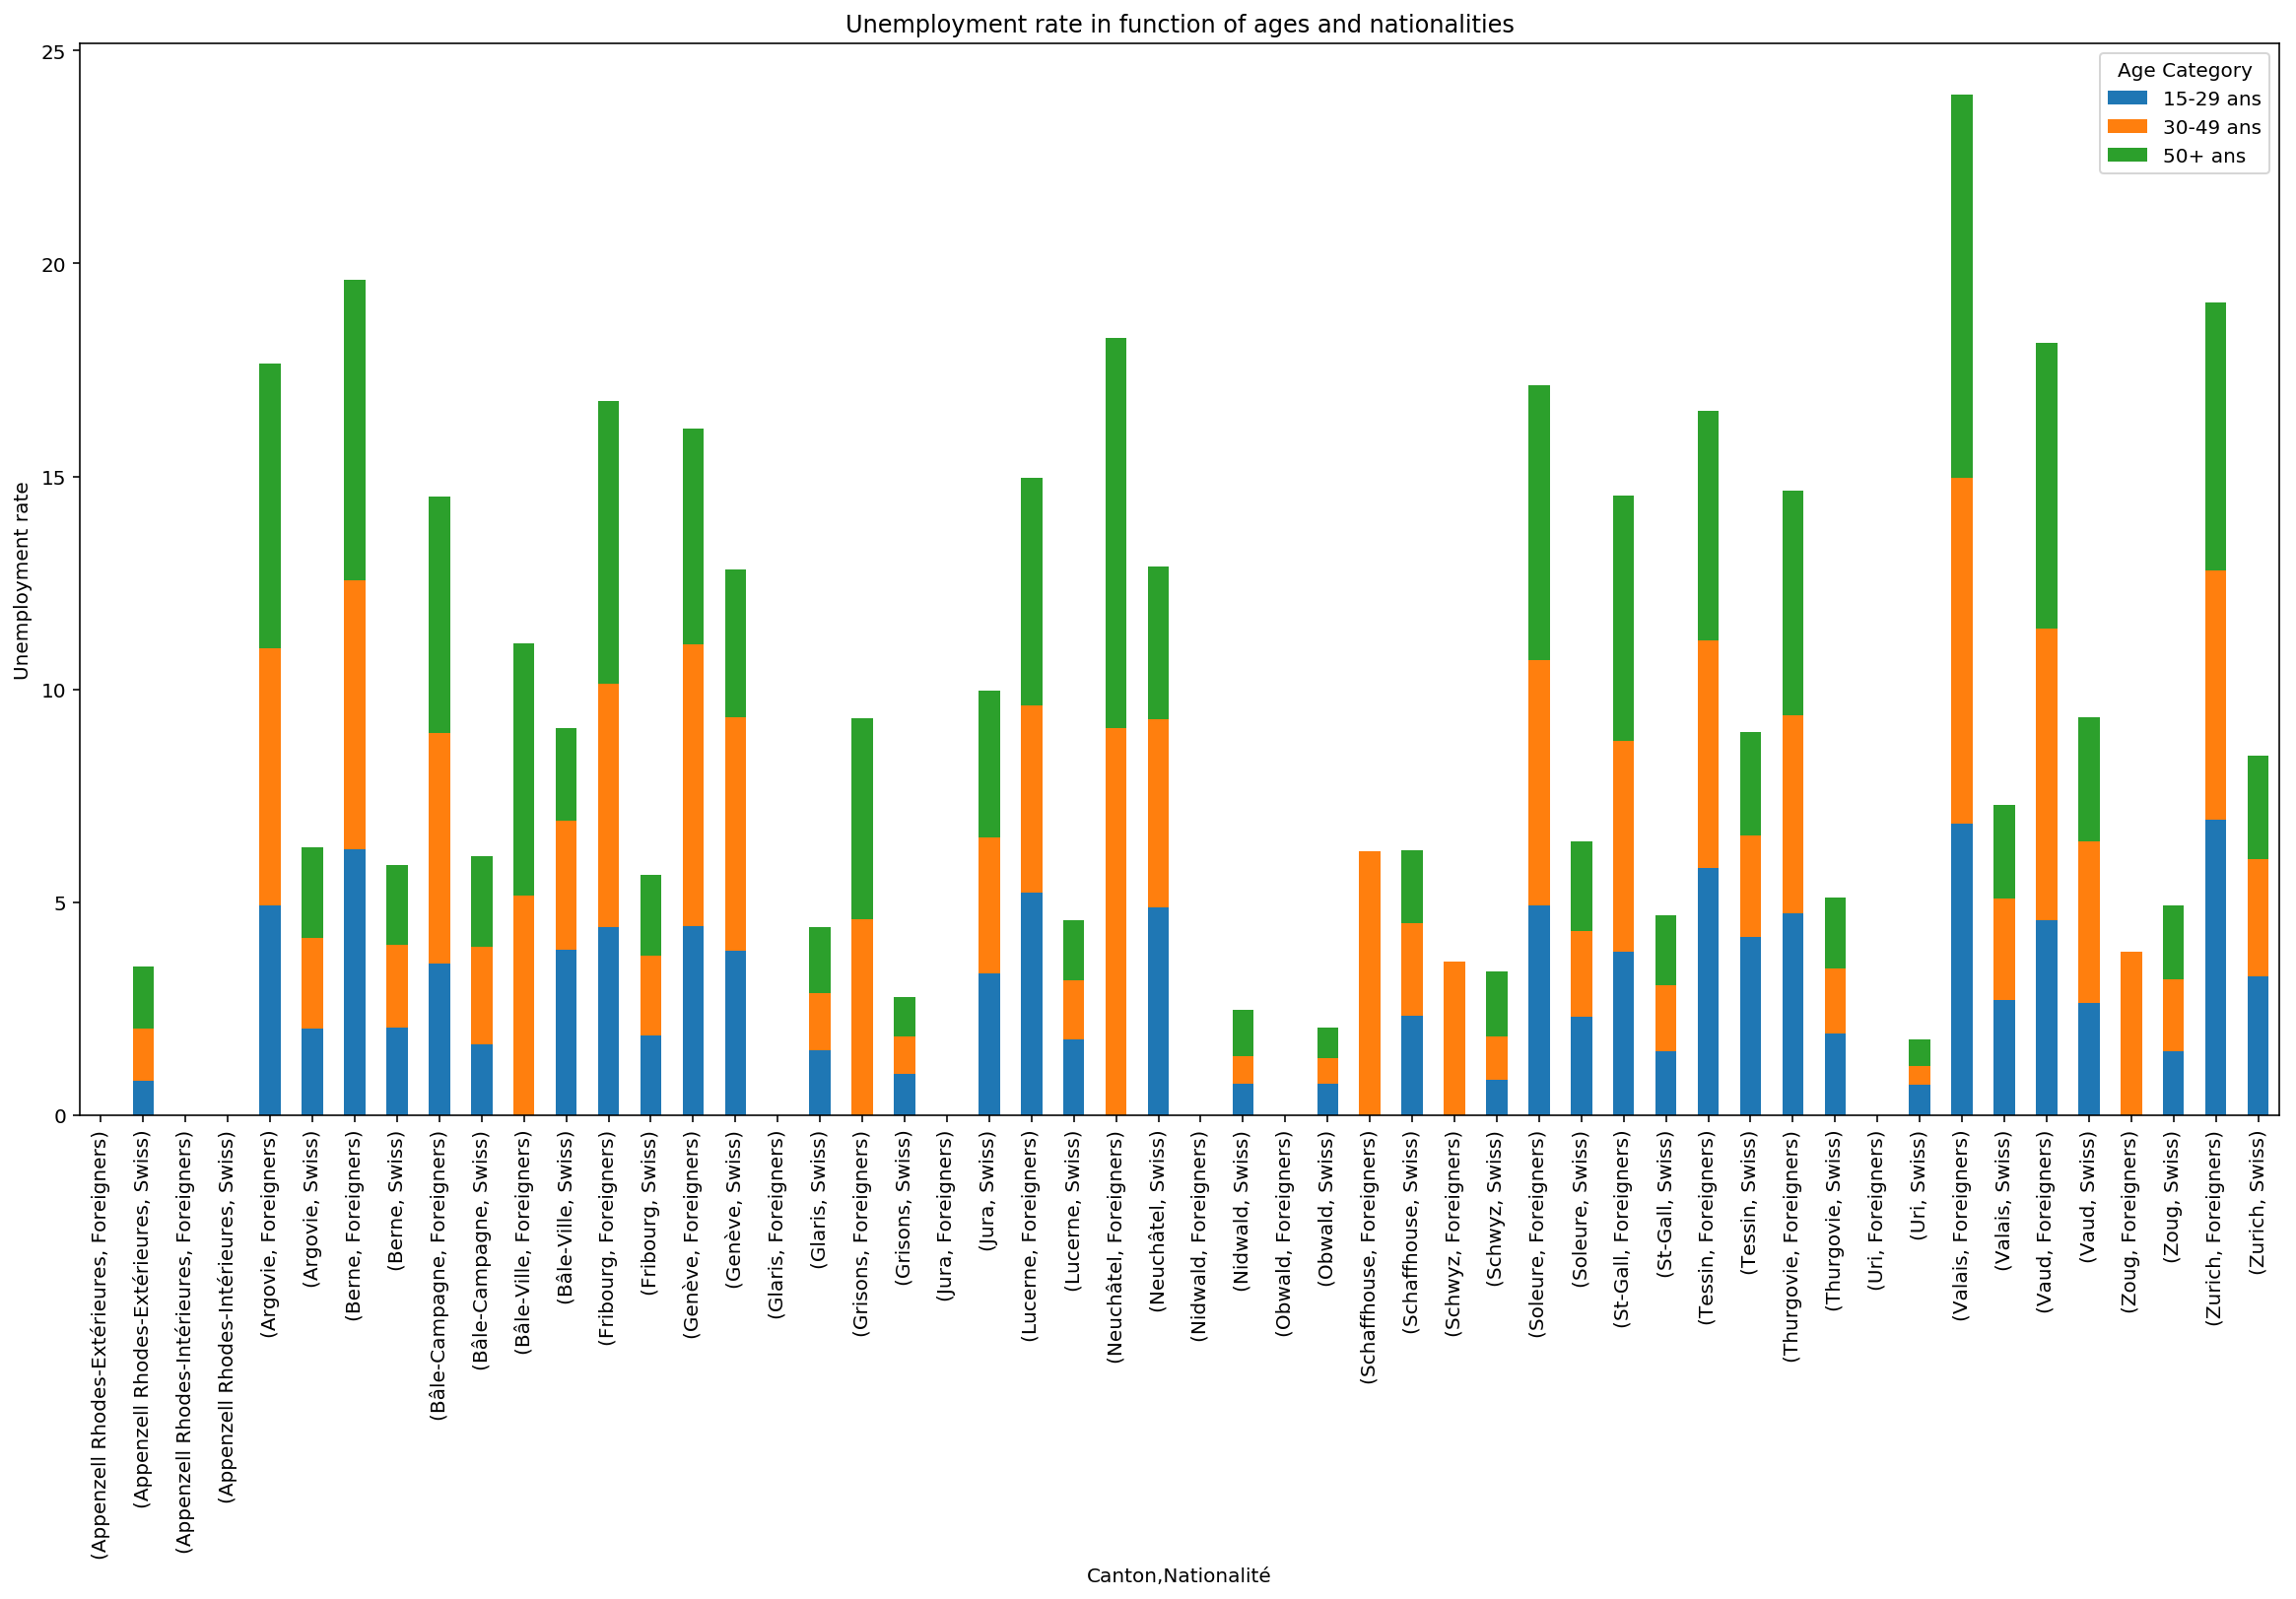

In [27]:
plot_df = age_nationalities_df.plot(kind='bar', stacked=True, figsize=(20,10), 
                          title='Unemployment rate in function of ages and nationalities')
plot_df.set_ylabel('Unemployment rate')                         
plt.show()

First, every column or part of column set to 0 has been set so because of missing data. Now we can see that the foreigners, specifically the old population among them are really worse off. Which would make sense since most of the time it's harder for them to find any work compared to older Swiss people. Other than that we can see that usually the younger population is worse off. Quite obviously, the swiss population is also better off than the foreign one.

# 4. Bonus: Unemployment rates between the areas divided by the Röstigraben

Consistently, on the Romand side of the Röstigraben, the unemployment rate is quite higher compared to the deutsche side. We can see roughly a 2 to 3 points difference in percentage inbetween the two. 